# Data Modelling

# Import Libraries

In [228]:
import pandas as pd
import numpy as np

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC

In [2]:
data = pd.read_csv("cleaned_dataset.csv")
data.drop("Unnamed: 0",axis=1)

,title,reddit_question,subreddit,human_response,created_utc,chatgpt_response,human_sentence_length,chatgpt_sentence_length,reddit_sentence_length,reddit_clauses,...,chatgpt_clauses,reddit_unique_word_ratio,human_unique_word_ratio,chatgpt_unique_word_ratio,human_slang_count,chatgpt_slang_count,human_punctuation_count,chatgpt_punctuation_count,reddit_slang_count,reddit_punctuation_count
0,I think my mums phone has been attacked with a...,Hi I believe my mum has recently installed som...,techsupport,Factory reset.,1.695151e+09,The easiest way to stop this is to try and res...,2,42,85,5,...,5,0.764706,1.000000,0.619048,0,0,1,5,0,7
1,PC acting on its own,"Hi all, last night I had a few strange issues ...",techsupport,If you suspect you may have malware on your co...,1.695146e+09,There could be a few reasons why your PC is ex...,58,42,150,17,...,5,0.726667,0.810345,0.833333,0,0,35,5,0,18
2,Does installing windows 10 through iso affect ...,I don't have a disc or usb to create a bootabl...,techsupport,Nope. Windows will mount the ISO file as if it...,1.695141e+09,There is no difference between using a disc or...,44,44,59,6,...,5,0.830508,0.909091,0.750000,0,0,5,3,0,7
3,Only my roommates PC and phone will not work p...,"Only certain websites work for him on PC, like...",techsupport,Do you have a newer computer and phone compare...,1.695141e+09,It's possible that your computer is not suppor...,20,43,58,6,...,3,0.896552,0.950000,0.720930,0,0,2,5,0,18
4,"PC is stuck on BIOS screen, cannot press any k...",I built my brother a pc a few days ago from ol...,techsupport,I would try to pull the cmos battery and reset...,1.695140e+09,Thanks,19,1,163,12,...,1,0.625767,0.894737,1.000000,0,0,1,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3417,Hollandaise sauce used in oven,"Hi, new here so sorry if this isn’t well poste...",AskCulinary,In Denmark we are trained with two classic var...,1.695064e+09,!,55,1,105,12,...,1,0.742857,0.818182,1.000000,0,0,7,1,0,8
3418,Do I need to join academia to connect with aca...,Hi guys. I'm an avid reader and lover of knowl...,AskAcademia,Asacademics it can be challenging to find the ...,1.692433e+09,!,93,1,216,28,...,1,0.717593,0.731183,1.000000,0,0,11,1,0,34
3419,Flying with cold smoked fish,"I'm on vacation, and went to a grocery store t...",AskCulinary,How long is the flight? They need to stay cold...,1.692368e+09,!,54,1,80,8,...,1,0.825000,0.888889,1.000000,0,0,5,1,0,10
3420,How do I cook marinated chicken to make it shr...,Title. \n\nI really only know how to throw chi...,AskCulinary,Crock pot would be the easiest way. Add enough...,1.691785e+09,!,30,1,84,10,...,1,0.678571,0.966667,1.000000,0,0,4,1,0,7


In [3]:
data.shape

(3422, 22)

# Preprocessing

So since we are creating a binary classification model we need to rearrange my data to simple two columns. The text being one and the label being the second. The label will be 1 if human and 0 if chatgpt. At first I was under the assumption that we would be analying the reddit questions as well but in the case of binary classificaiton we need to train our data on human and ai response and then have it make a decision. I will add teh reddit question as a column to just for my own visual purposes. It wont be in the model

In [4]:
human_df = data[['reddit_question', 'human_response']].copy()
human_df['label'] = 1 
human_df.rename(columns={'human_response': 'response'}, inplace=True)

chatgpt_df = data[['reddit_question', 'chatgpt_response']].copy()
chatgpt_df['label'] = 0 
chatgpt_df.rename(columns={'chatgpt_response': 'response'}, inplace=True)

text_data = pd.concat([human_df, chatgpt_df], ignore_index=True)

text_data.head()

,reddit_question,response,label
0,Hi I believe my mum has recently installed som...,Factory reset.,1
1,"Hi all, last night I had a few strange issues ...",If you suspect you may have malware on your co...,1
2,I don't have a disc or usb to create a bootabl...,Nope. Windows will mount the ISO file as if it...,1
3,"Only certain websites work for him on PC, like...",Do you have a newer computer and phone compare...,1
4,I built my brother a pc a few days ago from ol...,I would try to pull the cmos battery and reset...,1


In [5]:
text_data['label'].value_counts()

1    3422
0    3422
Name: label, dtype: int64

Before I continue with additional text preprocessing I will split my data into X and y and create my train test split

In [6]:
X = text_data['response']
y = text_data['label'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

Next I will create my CVEC and TVEC instances that I will be building my models on. We will fit the vectorize on the training data in order to train our models on them. We also need to transform the test data as well but will not do a fit transform as it is not supposed to see the data

In [7]:
cvec = CountVectorizer()
tvec = TfidfVectorizer()

In [8]:
cvec.fit(X_train,y_train)

CountVectorizer()

In [9]:
tvec.fit(X_train,y_train)

TfidfVectorizer()

In [10]:
X_train_cvec = cvec.transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [11]:
X_train_tvec = tvec.transform(X_train)
X_test_tvec = tvec.transform(X_test)

At this point I am going to vectorizer the text I will do a TFID and a CountVec eventually. 

# Modeling

### Baseline Accuracy

In [12]:
y_train.value_counts(normalize=True)

1    0.500091
0    0.499909
Name: label, dtype: float64

I am re train test splitting here to actually begin the modeling. Will go back and the address the code made above

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [14]:
stopwords = set(nltk.corpus.stopwords.words('english'))

In [46]:
nltk_stop = stopwords.words('english')


##### In order to not explain multiples timeswhat I am doing after each model and just provide my analysis I will explain up here what is about to follow.

##### I will be testing out both CountVectorizer and TFIDfVectorizer Pipes for Logistic Regression, Bernouli, and Multinomial. The initial parameters will be as follow:

###### 'cvec__max_features': [1000, 5000],
######    'cvec__min_df': [3, 5],
######    'cvec__max_df': [0.9, 0.95],
######    'cvec__ngram_range': [(1, 1), (1, 2)],
######    'cvec__stop_words': [stopwords]

##### After using that parameter sets for all the classification models I want to test out I will then create a confusion matrix. For each matrix I will look for recall, senstivity, specificity. and f1 score. Given the problem statment of this project the thing we would like to optimize for is accuracy. There isnt any realy life dangers and implications around false negatives or false positives but ratehr just be as accurate as possible.

##### After I complete this runthrough of initiatl modelling I will single out the best model and then optimize for that

### Logistic Regression CVEC

In [15]:
pipe_cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [16]:
params_cvec_lr = {
    'cvec__max_features': [1000,5000],
    'cvec__min_df': [3, 5],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [None, 'english', nltk_stop]
}

In [17]:
grid_cvec_lr = GridSearchCV(pipe_cvec_lr, params_cvec_lr, cv=5)
grid_cvec_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 5000],
                         'cvec__min_df': [3, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [{'a', 'about', 'above', 'after',
                                               'again', 'against', 'ain', 'all',
                                               'am', 'an', 'and', 'any', 'are',
                                               'aren', "aren't", 'as', 'at',
                                               'be', 'because', 'been',
                                               'before', 'being', 'below',
                                               'between', 'both', 'but', 'by',
                                               'can', 'couldn', "couldn

In [18]:
#Best score
best = grid_cvec_lr.best_score_
#Train score
train_s = grid_cvec_lr.score(X_train, y_train)
#Test score and accuracy
test_s = grid_cvec_lr.score(X_test, y_test)

In [19]:
print(f'CVEC Logistic Regression had a best score of: {best}')
print(f'CVEC Logistic Regression had a train score of: {train_s}')
print(f'CVEC Logistic Regression had a test score of: {test_s}')

CVEC Logistic Regression had a best score of: 0.7810250817884405
CVEC Logistic Regression had a train score of: 0.9657579062159215
CVEC Logistic Regression had a test score of: 0.798140770252324


In [100]:
grid_cvec_lr.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': {'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'must

In [20]:
#Prediction
preds_cvec_lr = grid_cvec_lr.predict(X_test)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec_lr).ravel()

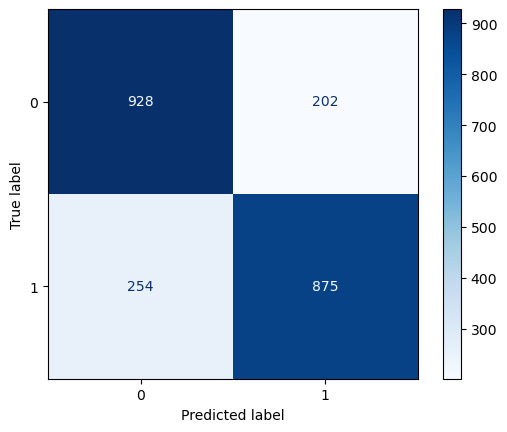

In [21]:
ConfusionMatrixDisplay.from_estimator(grid_cvec_lr, X_test, y_test, cmap='Blues', values_format='d');

In [22]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_cvec_lr)

In [23]:
print(f'CVEC Logistic Regression had a sensitivity of: {sensitivity}')
print(f'CVEC Logistic Regression had a specificty of: {specificity}')
print(f'CVEC Logistic Regression had a f1 score of: {f1}')

CVEC Logistic Regression had a sensitivity of: 0.775022143489814
CVEC Logistic Regression had a specificty of: 0.8212389380530973
CVEC Logistic Regression had a f1 score of: 0.7932910244786945


We have a really nice train score and decent test score. Overall the model is training well but could do better to unseen data. When looking at the best parameters we can tell that more ngrams and more features is ideal but for the sake of testing multiple models we will keep the params low for each model and improve on the best one.

Overall I would like to go off f1 score since 0 or 1 are not exclsuively more important than one another. We need to do well in both deparments. Overall the f1 score is okay.

---

### Logistic Regression TVEC

In [25]:
pipe_tvec_lr = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [26]:
params_tvec_lr = {
    'tvec__max_features': [1000, 5000],
    'tvec__min_df': [3, 5],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__stop_words': [None, 'english', nltk_stop]
}

In [27]:
grid_tvec_lr = GridSearchCV(pipe_tvec_lr, params_tvec_lr, cv=5)
grid_tvec_lr.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 5000],
                         'cvec__min_df': [3, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [{'a', 'about', 'above', 'after',
                                               'again', 'against', 'ain', 'all',
                                               'am', 'an', 'and', 'any', 'are',
                                               'aren', "aren't", 'as', 'at',
                                               'be', 'because', 'been',
                                               'before', 'being', 'below',
                                               'between', 'both', 'but', 'by',
                                               'can', 'couldn', "couldn

In [28]:
#Best score
best = grid_tvec_lr.best_score_
#Train score
train_s = grid_tvec_lr.score(X_train, y_train)
#Test score and accuracy
test_s = grid_tvec_lr.score(X_test, y_test)

In [29]:
print(f'TVEC Logistic Regression had a best score of: {best}')
print(f'TVEC Logistic Regression had a train score of: {train_s}')
print(f'TVEC Logistic Regression had a test score of: {test_s}')

TVEC Logistic Regression had a best score of: 0.801526717557252
TVEC Logistic Regression had a train score of: 0.9092693565976009
TVEC Logistic Regression had a test score of: 0.8078795927401505


In [101]:
grid_tvec_lr.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': {'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'must

In [58]:
#Prediction
preds_tvec_lr = grid_tvec_lr.predict(X_test)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec_lr).ravel()

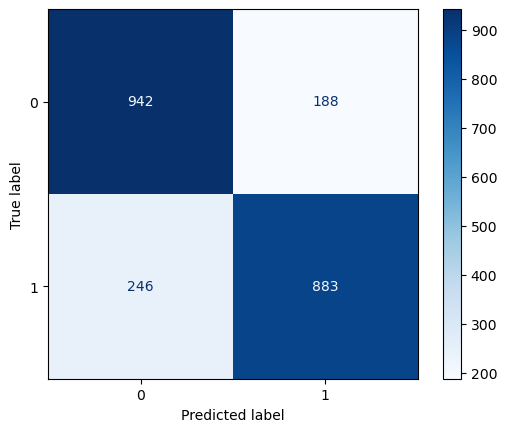

In [59]:
ConfusionMatrixDisplay.from_estimator(grid_tvec_lr, X_test, y_test, cmap='Blues', values_format='d');

In [60]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_tvec_lr)

In [61]:
print(f'TVEC Logistic Regression had a sensitivity of: {sensitivity}')
print(f'TVEC Logistic Regression had a specificty of: {specificity}')
print(f'TVEC Logistic Regression had a f1 score of: {f1}')

TVEC Logistic Regression had a sensitivity of: 0.7821080602302923
TVEC Logistic Regression had a specificty of: 0.8336283185840708
TVEC Logistic Regression had a f1 score of: 0.8027272727272727


When we do the same logistic regression but with a TFIDF we see a slight improvement as expected all around. Again our model wants more and more features but overall an okay train score and okay test score

---

### Bernouli Regression CVEC

In [43]:
pipe_cvec_bnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('bnb', BernoulliNB())
])

In [47]:
params_cvec_bnb = {
    'cvec__max_features': [1000, 5000],
    'cvec__min_df': [3, 5],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [None, 'english', nltk_stop]
}

In [48]:
grid_cvec_bnb = GridSearchCV(pipe_cvec_bnb, params_cvec_bnb, cv=5)
grid_cvec_bnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 5000],
                         'cvec__min_df': [3, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                        

In [49]:
#Best score
best = grid_cvec_bnb.best_score_
#Train score
train_s = grid_cvec_bnb.score(X_train, y_train)
#Test score and accuracy
test_s = grid_cvec_bnb.score(X_test, y_test)

In [62]:
print(f'CVEC Bernoulli Regression had a best score of: {best}')
print(f'CVEC Bernoulli Regression had a train score of: {train_s}')
print(f'CVEC Bernoulli Regression had a test score of: {test_s}')

CVEC Bernoulli Regression had a best score of: 0.7627044711014177
CVEC Bernoulli Regression had a train score of: 0.7736095965103599
CVEC Bernoulli Regression had a test score of: 0.7583001328021248


In [102]:
grid_cvec_bnb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 5,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [63]:
#Prediction
preds_cvec_bnb = grid_cvec_bnb.predict(X_test)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec_bnb).ravel()

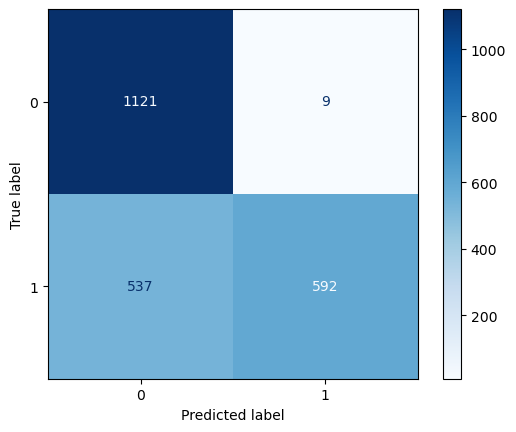

In [68]:
ConfusionMatrixDisplay.from_estimator(grid_cvec_bnb, X_test, y_test, cmap='Blues', values_format='d');

In [69]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_cvec_bnb)

In [76]:
print(f'CVEC Bernoulli Regression had a sensitivity of: {sensitivity}')
print(f'CVEC Bernoulli Regression had a specificty of: {specificity}')
print(f'CVEC Bernoulli Regression had a f1 score of: {f1}')

CVEC Bernoulli Regression had a sensitivity of: 0.5243578387953941
CVEC Bernoulli Regression had a specificty of: 0.9920353982300885
CVEC Bernoulli Regression had a f1 score of: 0.6843930635838149


When it comes to bernoulli regression the model does poor on both train and test and more importantly it doesnt absolutely terrible on sensitivity. This is a model we can completely ignore

---

### Bernouli Regression TVEC

In [55]:
pipe_tvec_bnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('bnb', BernoulliNB())
])

In [56]:
params_tvec_bnb = {
    'tvec__max_features': [1000, 5000],
    'tvec__min_df': [3, 5],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__stop_words': [None, 'english', nltk_stop]
}

In [57]:
grid_tvec_bnb = GridSearchCV(pipe_tvec_bnb, params_tvec_bnb, cv=5)
grid_tvec_bnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('bnb', BernoulliNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [1000, 5000],
                         'tvec__min_df': [3, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                        

In [71]:
#Best score
best = grid_tvec_bnb.best_score_
#Train score
train_s = grid_tvec_bnb.score(X_train, y_train)
#Test score and accuracy
test_s = grid_tvec_bnb.score(X_test, y_test)

In [72]:
print(f'TVEC Bernoulli Regression had a best score of: {best}')
print(f'TVEC Bernoulli Regression had a train score of: {train_s}')
print(f'TVEC Bernoulli Regression had a test score of: {test_s}')

TVEC Bernoulli Regression had a best score of: 0.7627044711014177
TVEC Bernoulli Regression had a train score of: 0.7736095965103599
TVEC Bernoulli Regression had a test score of: 0.7583001328021248


In [103]:
grid_tvec_bnb.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': None}

In [73]:
#Prediction
preds_tvec_bnb = grid_tvec_bnb.predict(X_test)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec_bnb).ravel()

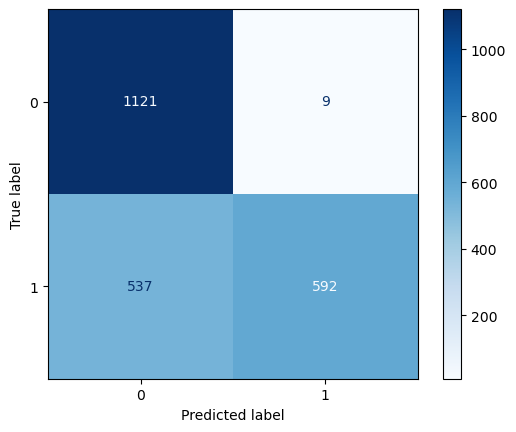

In [77]:
ConfusionMatrixDisplay.from_estimator(grid_tvec_bnb, X_test, y_test, cmap='Blues', values_format='d');

In [78]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_tvec_bnb)

In [79]:
print(f'TVEC Bernoulli had a sensitivity of: {sensitivity}')
print(f'TVEC Bernoulli Regression had a specificty of: {specificity}')
print(f'TVEC Bernoulli Regression had a f1 score of: {f1}')

TVEC Bernoulli had a sensitivity of: 0.5243578387953941
TVEC Bernoulli Regression had a specificty of: 0.9920353982300885
TVEC Bernoulli Regression had a f1 score of: 0.6843930635838149


Wanted to see if we would get much improvement with TFIDF on Bernoulli but its just as bad. However it did insanely well on specificity but the tradeoff on sensitivity is not worth it

### Multinomial Regression CVEC

In [80]:
pipe_cvec_mnb = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [81]:
params_cvec_mnb = {
    'cvec__max_features': [1000, 5000],
    'cvec__min_df': [3, 5],
    'cvec__max_df': [0.9, 0.95],
    'cvec__ngram_range': [(1, 1), (1, 2)],
    'cvec__stop_words': [None, 'english', nltk_stop]
}

In [82]:
grid_cvec_mnb = GridSearchCV(pipe_cvec_mnb, params_cvec_mnb, cv=5)
grid_cvec_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [1000, 5000],
                         'cvec__min_df': [3, 5],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                      

In [83]:
#Best score
best = grid_cvec_mnb.best_score_
#Train score
train_s = grid_cvec_mnb.score(X_train, y_train)
#Test score and accuracy
test_s = grid_cvec_mnb.score(X_test, y_test)

In [104]:
grid_cvec_mnb.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 5000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [84]:
print(f'CVEC Multinomial Regression had a best score of: {best}')
print(f'CVEC Multinomial Regression had a train score of: {train_s}')
print(f'CVEC Multinomial Regression had a test score of: {test_s}')

CVEC Multinomial Regression had a best score of: 0.759432933478735
CVEC Multinomial Regression had a train score of: 0.8239912758996728
CVEC Multinomial Regression had a test score of: 0.7618415227976981


In [85]:
#Prediction
preds_cvec_mnb = grid_cvec_mnb.predict(X_test)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_cvec_mnb).ravel()

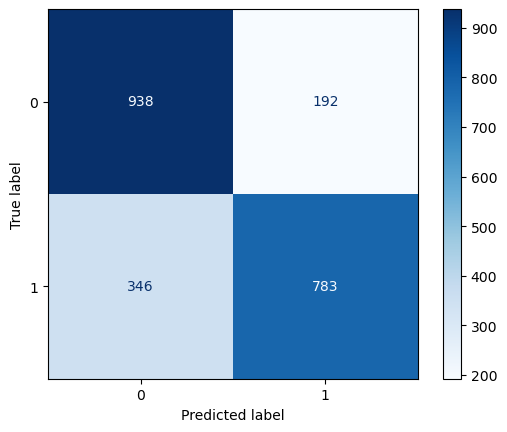

In [86]:
ConfusionMatrixDisplay.from_estimator(grid_cvec_mnb, X_test, y_test, cmap='Blues', values_format='d');

In [87]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_cvec_mnb)

In [88]:
print(f'CVEC Multinomial Regression had a sensitivity of: {sensitivity}')
print(f'CVEC Multinomial Regression had a specificty of: {specificity}')
print(f'CVEC Multinomial Regression had a f1 score of: {f1}')

CVEC Multinomial Regression had a sensitivity of: 0.6935341009743136
CVEC Multinomial Regression had a specificty of: 0.8300884955752212
CVEC Multinomial Regression had a f1 score of: 0.744296577946768


Multinomial is not performing the best here as well on our training data as our test data almost beats it out. So as expected the sensitivity and the specificity are going to be low. I think we wont see much change once we use TFID here as well.

---

### Multinomial Regression TVEC

In [89]:
pipe_tvec_mnb = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

In [90]:
params_tvec_mnb = {
    'tvec__max_features': [1000, 5000],
    'tvec__min_df': [3, 5],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1, 1), (1, 2)],
    'tvec__stop_words': [None, 'english', nltk_stop]
}

In [91]:
grid_tvec_mnb = GridSearchCV(pipe_tvec_mnb, params_tvec_mnb, cv=5)
grid_tvec_mnb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [1000, 5000],
                         'tvec__min_df': [3, 5],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                      

In [92]:
#Best score
best = grid_tvec_mnb.best_score_
#Train score
train_s = grid_tvec_mnb.score(X_train, y_train)
#Test score and accuracy
test_s = grid_tvec_mnb.score(X_test, y_test)

In [93]:
print(f'TVEC Multinomial Regression had a best score of: {best}')
print(f'TVEC Multinomial Regression had a train score of: {train_s}')
print(f'TVEC Multinomial Regression had a test score of: {test_s}')

TVEC Multinomial Regression had a best score of: 0.7766630316248636
TVEC Multinomial Regression had a train score of: 0.8344601962922573
TVEC Multinomial Regression had a test score of: 0.7755644090305445


In [105]:
grid_tvec_mnb.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [94]:
#Prediction
preds_tvec_mnb = grid_tvec_mnb.predict(X_test)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec_mnb).ravel()

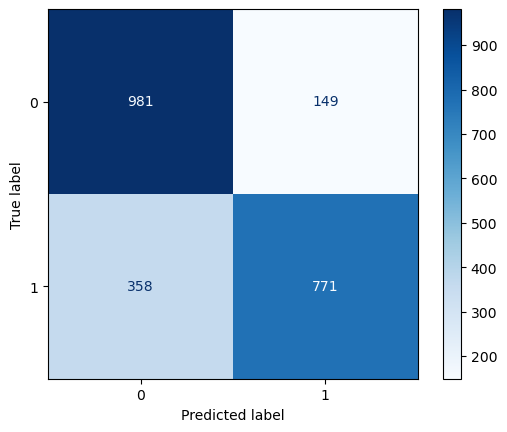

In [95]:
ConfusionMatrixDisplay.from_estimator(grid_tvec_mnb, X_test, y_test, cmap='Blues', values_format='d');

In [96]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_tvec_mnb)

In [97]:
print(f'TVEC Multinomial Regression had a sensitivity of: {sensitivity}')
print(f'TVEC Multinomial Regression had a specificty of: {specificity}')
print(f'TVEC Multinomial Regression had a f1 score of: {f1}')

TVEC Multinomial Regression had a sensitivity of: 0.6829052258635961
TVEC Multinomial Regression had a specificty of: 0.868141592920354
TVEC Multinomial Regression had a f1 score of: 0.752562225475842


As expected not a whole lot of change done on the TFID version of of multinomial. I think we are done Naive Bayes all together.

---

In this next section I am going going to be using bagging classifier with a few base estimator but definitely with Logistic Regression as its our best thus far. I am going to do the same as above though. Fit and score the models, create confusion matrix and provide analysis

---

### Bagging Classifier with DecisionTree with TVEC

In [275]:
tvec = TfidfVectorizer(stop_words='english')

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

In [276]:
params_bag_dtc = {
    'n_estimators' : [50, 100,150],
    'base_estimator__max_depth' : [3, 5]
}

In [277]:
grid_bag_dtc = GridSearchCV(estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier()),
                   param_grid=params_bag_dtc,
                   cv = 5, verbose=1)

In [278]:
grid_bag_dtc.fit(X_train_tvec, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier()),
             param_grid={'base_estimator__max_depth': [3, 5],
                         'n_estimators': [50, 100, 150]},
             verbose=1)

In [279]:
grid_bag_dtc.best_params_

{'base_estimator__max_depth': 5, 'n_estimators': 50}

In [280]:
best_bag_dtc = grid_bag_dtc.best_estimator_

best_bag_dtc.fit(X_train_tvec, y_train)

print(f'Bagging Classifier base of DTC had a train score of: {best_bag_dtc.score(X_train_tvec, y_train)}')
print(f'Bagging Classifier base of DTC had a test score of: {best_bag_dtc.score(X_test_tvec, y_test)}')

Bagging Classifier base of DTC had a train score of: 0.7271537622682661
Bagging Classifier base of DTC had a test score of: 0.7118193891102258


In [281]:
#Prediction
preds_bag_dtc = grid_bag_dtc.predict(X_test_tvec)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_bag_dtc).ravel()

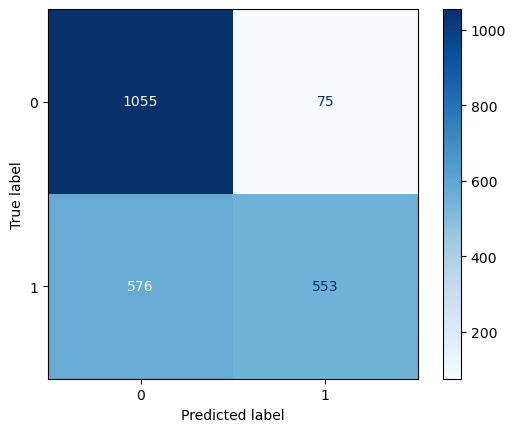

In [282]:
ConfusionMatrixDisplay.from_estimator(grid_bag_dtc, X_test_tvec, y_test, cmap='Blues', values_format='d');

In [283]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_bag_dtc)

In [284]:
print(f'Bagging with a base DTC had a sensitivity of: {sensitivity}')
print(f'Bagging with a base DTC had a specificty of: {specificity}')
print(f'Bagging with a base DTC had a f1 score of: {f1}')

Bagging with a base DTC had a sensitivity of: 0.48981399468556247
Bagging with a base DTC had a specificty of: 0.9336283185840708
Bagging with a base DTC had a f1 score of: 0.6294820717131474


Moving forward I am only using TFIDF for sake of time and that it always does better than CVEC for all of the above models.

On bagging classifiers I kind of expect this one to be the best specifically with logistic regression just because I am not sold that trees are the best use case here, the type of questions asked at each depth in my opinion doesnt seem to get us any closer to a classification than logistic regression would do.

Interestingly enough the train and test data performs poorly and I beleive this is our worst sensitivity and f1 score thus far. So bad I dont think I want to use anymore trees moving forward so I will try bagging again with logistic Regression

---

### Bagging Classifier with Logistic Regression with TVEC

In [285]:
params_bag_lr = {
    'n_estimators' : [50]
}

In [286]:
grid_bag_lr = GridSearchCV(estimator=BaggingClassifier(base_estimator=LogisticRegression()),
                   param_grid=params_bag_lr,
                   cv = 5, verbose=1)

In [287]:
grid_bag_lr.fit(X_train_tvec, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=LogisticRegression()),
             param_grid={'n_estimators': [50]}, verbose=1)

In [183]:
best_bag_lr = grid_bag_lr.best_estimator_

best_bag_lr.fit(X_train_tvec, y_train)

print(f'Bagging Classifier base of LR had a train score of: {best_bag_lr.score(X_train_tvec, y_train)}')
print(f'Bagging Classifier base of RL had a test score of: {best_bag_lr.score(X_test_tvec, y_test)}')

Bagging Classifier base of LR had a train score of: 0.9637949836423119
Bagging Classifier base of RL had a test score of: 0.7950420540061974


In [288]:
#Prediction
preds_bag_lr = grid_bag_lr.predict(X_test_tvec)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_bag_lr).ravel()

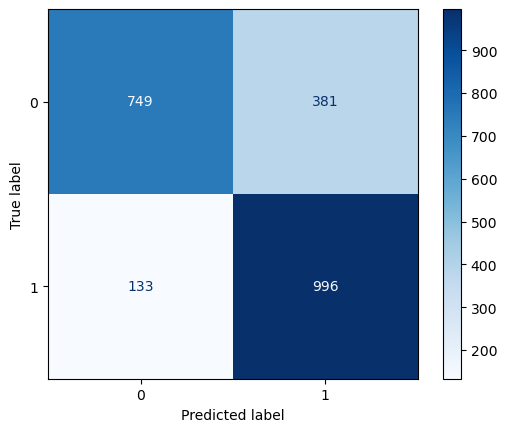

In [289]:
ConfusionMatrixDisplay.from_estimator(grid_bag_lr, X_test_cvec, y_test, cmap='Blues', values_format='d');

In [290]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_bag_lr)

In [291]:
print(f'Bagging with a base LR had a sensitivity of: {sensitivity}')
print(f'Bagging with a base LR had a specificty of: {specificity}')
print(f'Bagging with a base LR had a f1 score of: {f1}')

Bagging with a base LR had a sensitivity of: 0.7440212577502214
Bagging with a base LR had a specificty of: 0.8389380530973451
Bagging with a base LR had a f1 score of: 0.7810320781032077


Unfortunately here I had to reduce the parameters significantly because it was taking 10 minutes to fit the model at times. However giving the results the train score does decently well and so does the test score in respect. Even when looking at our confusion matrix this model performs similarly to our TFIDF Logistic Regression above. I believe if we were to use on par parameters here as we did up there that this model would be our best one. However, just do to how long it took to run I dont think we can move forward with this model

---

At this point I dont think I will be using trees but I just wanted to try one last one to see how we do

### Random Forest Classifier

In [189]:
rf = RandomForestClassifier()

In [299]:
rf_params = {
    'n_estimators': [150,250],
    'max_depth': [None, 3,]
}

In [304]:
grid_rf = GridSearchCV(rf, param_grid=rf_params, cv=5, n_jobs=-1)
grid_rf.fit(X_train_tvec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 3], 'n_estimators': [150, 250]})

In [305]:
grid_rf.best_params_

{'max_depth': None, 'n_estimators': 250}

In [306]:
grid_rf.best_estimator_

RandomForestClassifier(n_estimators=250)

In [307]:
print(f'Random Forest Classifier had a train score of: {grid_rf.score(X_train_tvec, y_train)}')
print(f'Random Forest Classifier had a test score of: {grid_rf.score(X_test_tvec, y_test)}')

Random Forest Classifier had a train score of: 0.9980370774263904
Random Forest Classifier had a test score of: 0.8087649402390438


In [308]:
#Prediction
preds_rf = grid_rf.predict(X_test_tvec)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()

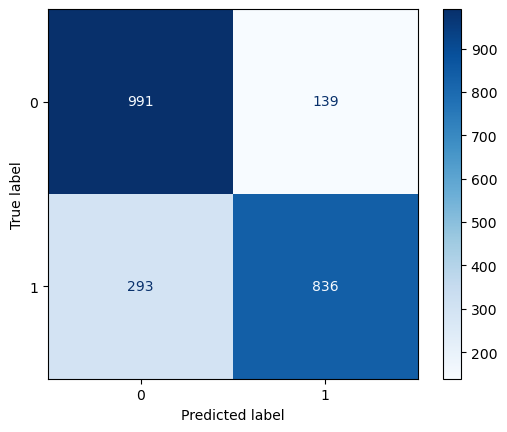

In [309]:
ConfusionMatrixDisplay.from_estimator(grid_rf, X_test_tvec, y_test, cmap='Blues', values_format='d');

In [310]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_rf)

In [311]:
print(f'RF had a sensitivity of: {sensitivity}')
print(f'RF had a specificty of: {specificity}')
print(f'RF had a f1 score of: {f1}')

RF had a sensitivity of: 0.7404782993799823
RF had a specificty of: 0.8769911504424779
RF had a f1 score of: 0.7946768060836502


Suprisingly the model did really well on the train data but poorly on the test in respect. Due to high bias its hard to take this model seriously but it does do somewhat decent on the sensitivity and specificity and f1 score. However its clear its best params are a n-estimator of 150. To increase this to a number for optimization may take incredibly long to run and not worth it. I tried it at 250 and it still doesnt do better than Logistic Regression

---

Below I am trying SVM just to try it out on low params. I am curous to see how it does. Same as before, we do fitting,scoring, matrix, and asses.

---

### SVM

In [312]:
svc = SVC()

In [313]:
svc.fit(X_train_tvec, y_train)

SVC()

In [314]:
preds_svc = svc.predict(X_test_tvec)

In [315]:
svc.score(X_train_tvec, y_train), svc.score(X_test_tvec, y_test)

(0.993020719738277, 0.7906153165117309)

In [316]:
preds_svc = svc.predict(X_test_tvec)

tn, fp, fn, tp = confusion_matrix(y_test, preds_svc).ravel()

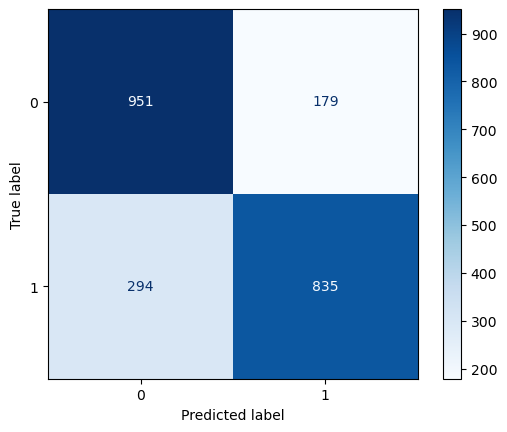

In [317]:
ConfusionMatrixDisplay.from_estimator(svc, X_test_tvec, y_test, cmap='Blues', values_format='d');

In [359]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_svc)

In [360]:
print(f'SVM had a sensitivity of: {sensitivity}')
print(f'SVM with a base LR had a specificty of: {specificity}')
print(f'SVM with a base LR had a f1 score of: {f1}')

SVM had a sensitivity of: 0.8184233835252436
SVM with a base LR had a specificty of: 0.8619469026548673
SVM with a base LR had a f1 score of: 0.7792813812412505


SVM actually did one of our best peformances all around. I am sure that if I took the teime to play with the C and the kernel that I could get this to perform a bit better but jsut knowing what we know about it being a black box method and runtime I would not like to use this model.

---

My anticipation going into ADA Boosting with Logistic Regression here will give us one of our best scores. I am only considering Logistic Regression as nothing else seems to be worth more time. Again we will fit, score, matrix, and asses

---

### Ada Boosting and Gradient Boosting

In [333]:
abc = AdaBoostClassifier(random_state=42, 
                   base_estimator=LogisticRegression(), 
                   n_estimators = 150)

abc.fit(X_train_tvec, y_train)

abc.score(X_train_tvec, y_train), abc.score(X_test_tvec, y_test)

(0.7585605234460197, 0.7224435590969456)

In [334]:
preds_abc = abc.predict(X_test_tvec)

In [335]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_abc).ravel()

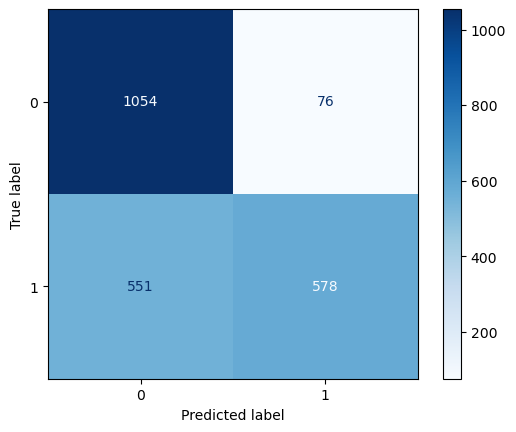

In [336]:
ConfusionMatrixDisplay.from_estimator(abc, X_test_tvec, y_test, cmap='Blues', values_format='d');

In [337]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_abc)

In [338]:
print(f'ABC with a base LR had a sensitivity of: {sensitivity}')
print(f'ABC with a base LR had a specificty of: {specificity}')
print(f'ABC with a base LR had a f1 score of: {f1}')

ABC with a base LR had a sensitivity of: 0.5119574844995571
ABC with a base LR had a specificty of: 0.9327433628318584
ABC with a base LR had a f1 score of: 0.6483454851374089


In [341]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train_tvec, y_train)

gbc.score(X_train_tvec, y_train), gbc.score(X_test_tvec, y_test)

(0.8198473282442749, 0.7724656927844179)

In [342]:
preds_gbc = gbc.predict(X_test_tvec)

In [343]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_gbc).ravel()

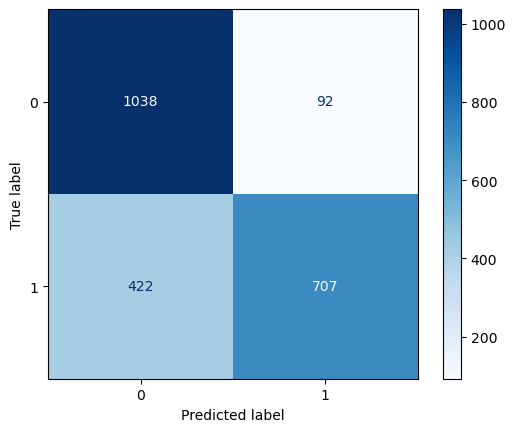

In [344]:
ConfusionMatrixDisplay.from_estimator(gbc, X_test_tvec, y_test, cmap='Blues', values_format='d');

In [345]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds_gbc)

In [346]:
print(f'ABC with a base LR had a sensitivity of: {sensitivity}')
print(f'ABC with a base LR had a specificty of: {specificity}')
print(f'ABC with a base LR had a f1 score of: {f1}')

ABC with a base LR had a sensitivity of: 0.6262178919397697
ABC with a base LR had a specificty of: 0.9185840707964602
ABC with a base LR had a f1 score of: 0.7334024896265561


When it comes to ada boosting and gradient boosting I am sure I can do more analysis here and investigative work but just given the initial scores I dont believe its worth the time. Maybe I having bad luck with trees but since GBC base is a DTC i am going to not consider it in the final model. With ada it did not perform well anywhere in my opnion.

### Best Overall Model: 

So it turns out our best performing model was indeed Logsitic Regression TFIDF. Here I am going to play around with the parameters to see how much I can improve the F1 Score

In [347]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [354]:
params = {
    'tvec__max_features': [15000,20000],
    'tvec__min_df': [3],
    'tvec__max_df': [0.9, 0.95],
    'tvec__ngram_range': [(1, 5), (1, 4)],
    'tvec__stop_words': [None, 'english', nltk_stop]
}

In [355]:
grid = GridSearchCV(pipe, params, cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'tvec__max_df': [0.9, 0.95],
                         'tvec__max_features': [15000, 20000],
                         'tvec__min_df': [3],
                         'tvec__ngram_range': [(1, 5), (1, 4)],
                         'tvec__stop_words': [None, 'english',
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                   

In [357]:
#Best score
best = grid.best_score_
#Train score
train_s = grid.score(X_train, y_train)
#Test score and accuracy
test_s = grid.score(X_test, y_test)
print(f'TVEC Logistic Regression had a best score of: {best}')
print(f'TVEC Logistic Regression had a train score of: {train_s}')
print(f'TVEC Logistic Regression had a test score of: {test_s}')

TVEC Logistic Regression had a best score of: 0.8444929116684842
TVEC Logistic Regression had a train score of: 0.9363140676117775
TVEC Logistic Regression had a test score of: 0.8397521027003099


In [358]:
grid.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': 15000,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 4),
 'tvec__stop_words': None}

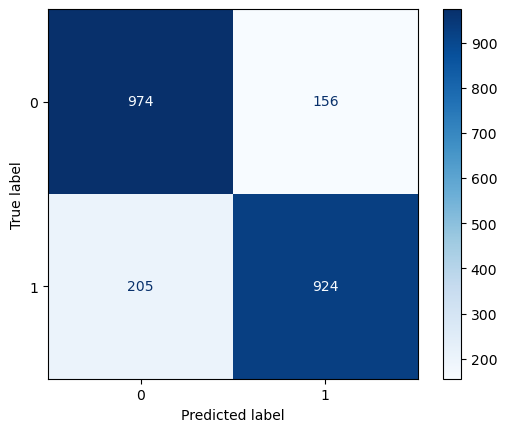

In [352]:
#Prediction
preds = grid.predict(X_test)
#Values for confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap='Blues', values_format='d');

In [353]:
#Sensitivity
sensitivity = tp / (tp+fn)
#Specificity
specificity  = tn/(tn+fp)
#F1 Score
f1 = f1_score(y_test, preds)
print(f'TVEC Logistic Regression had a sensitivity of: {sensitivity}')
print(f'TVEC Logistic Regression had a specificty of: {specificity}')
print(f'TVEC Logistic Regression had a f1 score of: {f1}')

TVEC Logistic Regression had a sensitivity of: 0.8184233835252436
TVEC Logistic Regression had a specificty of: 0.8619469026548673
TVEC Logistic Regression had a f1 score of: 0.8365776369397918


# Conclusion

In conclusion it turns out being able to create accurate labeling models requires tons of features, n gram sizes, or depths on a tree implying just limitless NLP can be at its core. I am sure there are much better models in existence that can do NLP and I am sure if we have super computers we can push the limits with the hyperparameter tuning but what we got is the best we could do. OVerall I believe we did our best to address our problem statement of if we can make the most optimal model possible at guessing both human and ai and not just one or the other. I will discuss further thoughts in my readme